<a href="https://colab.research.google.com/github/nabilah-afrin/Deep-learning-projects/blob/main/Binary%20Classification%20of%20Parkinson's%20Disease%20Using%20Self%20Attention%20Mechanism%20with%203D%20ResNet%20Architecture/analyzing_anatomical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [ ]:
path = r"/content/drive/MyDrive/Colab Notebooks/TAOwu2/sub-*/anat/*.nii.gz"

In [ ]:
!pip install nilearn
from nilearn import plotting
import pylab as plt
import cv2
import pandas as pd
import glob
import os
import re
import json
import nibabel as nib
import numpy as np
import numbers
from pathlib import Path
from matplotlib import pyplot as plt

/content/drive/MyDrive/Colab Notebooks/TAOwu2/sub-control032061/anat/sub-control032061_T1w.nii.gz
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 176 192 200   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [-1.  1.  1.  1.  2.  0.  0.  0.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'FSL5.0'
aux_file        : b''
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.08883946
quatern_c       : -0.9955246
quatern_d      

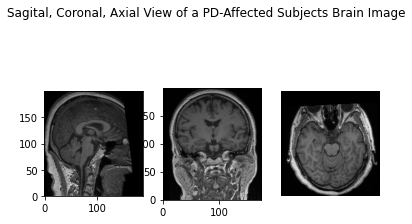

In [ ]:
dataset= 1
mid_slice = 1
for img in glob.glob(path):
    print(img)
    i= nib.load(img)
    print(i.header)
    dataset= i.get_fdata()
    #plt.hist(dataset, bins=10)
    #print(dataset)
def show_mid_slice(img_numpy, title='Sagital, Coronal, Axial View of a PD-Affected Subjects Brain Image'):
   """
   Accepts an 3D numpy array and shows median slices in all three planes
   """
   assert img_numpy.ndim == 3
   n_i, n_j, n_k = img_numpy.shape

   # sagittal (left image)
   center_i1 = int((n_i - 1) / 2)
   print(center_i1)
   # coronal (center image)
   center_j1 = int((n_j - 1) / 2)
   print(center_j1)
   # axial slice (right image)
   center_k1 = int((n_k - 1) / 2)
   print(center_k1)

   show_slices([img_numpy[center_i1, :, :],
                img_numpy[:, center_j1, :],
                img_numpy[:, :, center_k1]])
   #show_slices.plt.axis('off')
   plt.suptitle(title)


def show_slices(slices):
   """
   Function to display a row of image slices
   Input is a list of numpy 2D image slices
   """
   fig, axes = plt.subplots(1, len(slices))
   for i, slice in enumerate(slices):
       axes[i].imshow(slice.T, cmap="gray", origin="lower")
mid_slice = show_mid_slice(dataset)
mid_slice= plt.axis('off')#




61
65
69


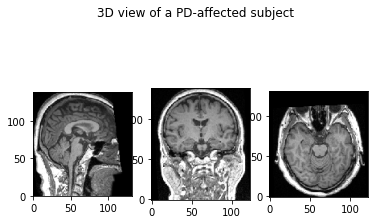

In [ ]:
import scipy
def resize_data_volume(data, dim):
    """
    Resize the data to the dim size
    """
    depth, height, width = data.shape
    scale = [dim[0] * 1.0 / depth, dim[1] * 1.0 / height, dim[2] * 1.0 / width]
    print(scale)
    return scipy.ndimage.interpolation.zoom(data, scale, order=0)

def resize_data_volume_by_scale(data, scale):
    """
    Resize the data based on the provided scale
    """
    scale_list = [scale,scale,scale]
    return scipy.ndimage.interpolation.zoom(data, scale_list, order=0)


result = resize_data_volume_by_scale(dataset, 0.7)
#result2 = resize_data_volume_by_scale(dataset, 5)
show_mid_slice(result)
#show_mid_slice(result2)

87
93
99


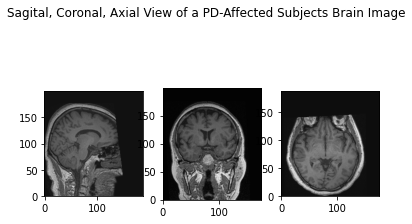

In [ ]:
import scipy.ndimage as ndimage
def random_zoom(matrix,min_percentage=0.7, max_percentage=1.2):
    z = np.random.sample() *(max_percentage-min_percentage) + min_percentage
    zoom_matrix = np.array([[z, 0, 0, 0],
                            [0, z, 0, 0],
                            [0, 0, z, 0],
                            [0, 0, 0, 1]])
    return ndimage.interpolation.affine_transform(matrix, zoom_matrix)




#show_mid_slice((dataset))
show_mid_slice(random_zoom(dataset))
#show_mid_slice(random_zoom(dataset))

87
97
102


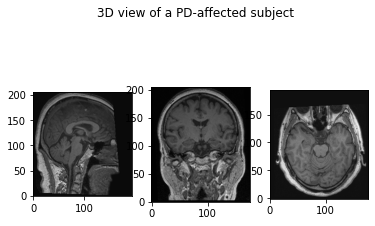

In [ ]:
def random_rotate3D(img_numpy, min_angle, max_angle):
   """
   Returns a random rotated array in the same shape
   :param img_numpy: 3D numpy array
   :param min_angle: in degrees
   :param max_angle: in degrees
   """
   assert img_numpy.ndim == 3, "provide a 3d numpy array"
   assert min_angle < max_angle, "min should be less than max val"
   assert min_angle > -360 or max_angle < 360
   all_axes = [(1, 0), (1, 2), (0, 2)]
   angle = np.random.randint(low=min_angle, high=max_angle+1)
   axes_random_id = np.random.randint(low=0, high=len(all_axes))
   axes = all_axes[axes_random_id]
   return scipy.ndimage.rotate(img_numpy, angle, axes=axes)
show_mid_slice(random_rotate3D(dataset,-30,30))
#plt.imshow(random_rotate3D(dataset,-20,20))

87
93
99
0.0 566.0
0.0 566.0
0.0 566.0


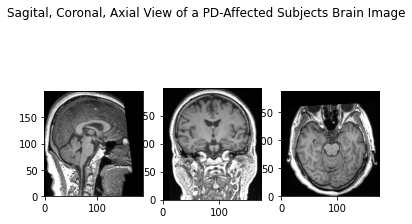

In [ ]:
def clip_range(img_numpy):
    """
    Cut off outliers that are related to detected black in the image (the air area)
    """
    zero_value = (img_numpy[0, 0, 0] + img_numpy[-1, 0, 0] + img_numpy[0, -1, 0] + \
                  img_numpy[0, 0, -1] + img_numpy[-1, -1, -1] + img_numpy[-1, -1, 0] \
                  + img_numpy[0, -1, -1] + img_numpy[-1, 0, -1]) / 8.0
    non_zeros_idx = np.where(img_numpy >= zero_value)
    [max_z, max_h, max_w] = np.max(np.array(non_zeros_idx), axis=1)
    [min_z, min_h, min_w] = np.min(np.array(non_zeros_idx), axis=1)
    y = img_numpy[min_z:max_z, min_h:max_h, min_w:max_w]
    return y


def percentile_clip(img_numpy, min_val=5, max_val=95):
    """
    Intensity normalization based on percentile
    Clips the range based on the quarile values.
    :param min_val: should be in the range [0,100]
    :param max_val: should be in the range [0,100]
    :return: intesity normalized image
    """
    low = np.percentile(img_numpy, min_val)
    high = np.percentile(img_numpy, max_val)

    img_numpy[img_numpy < low] = low
    img_numpy[img_numpy > high] = high
    return img_numpy


#show_mid_slice((dataset))
#show_mid_slice(clip_range(dataset))
show_mid_slice(percentile_clip(dataset))
print(dataset.min(),dataset.max())
print(clip_range(dataset).min(),clip_range(dataset).max())
print(percentile_clip(dataset).min(),percentile_clip(dataset).max())

In [ ]:
from matplotlib import pyplot as plt
def normalize_intensity(img_tensor, normalization="mean"):
    """
    Accepts an image tensor and normalizes it
    :param normalization: choices = "max", "mean" , type=str
    For mean normalization we use the non zero voxels only.
    """
    if normalization == "mean":
        mask = img_tensor.ne(0.0)
        desired = img_tensor[mask]
        mean_val, std_val = desired.mean(), desired.std()
        img_tensor = (img_tensor - mean_val) / std_val
    elif normalization == "max":
      MAX, MIN = img_tensor.max(), img_tensor.min()
      img_tensor = (img_tensor - MIN) / (MAX - MIN)
    return img_tensor
plt.imshow(normalize_intensity(dataset))

AttributeError: ignored